# FSC

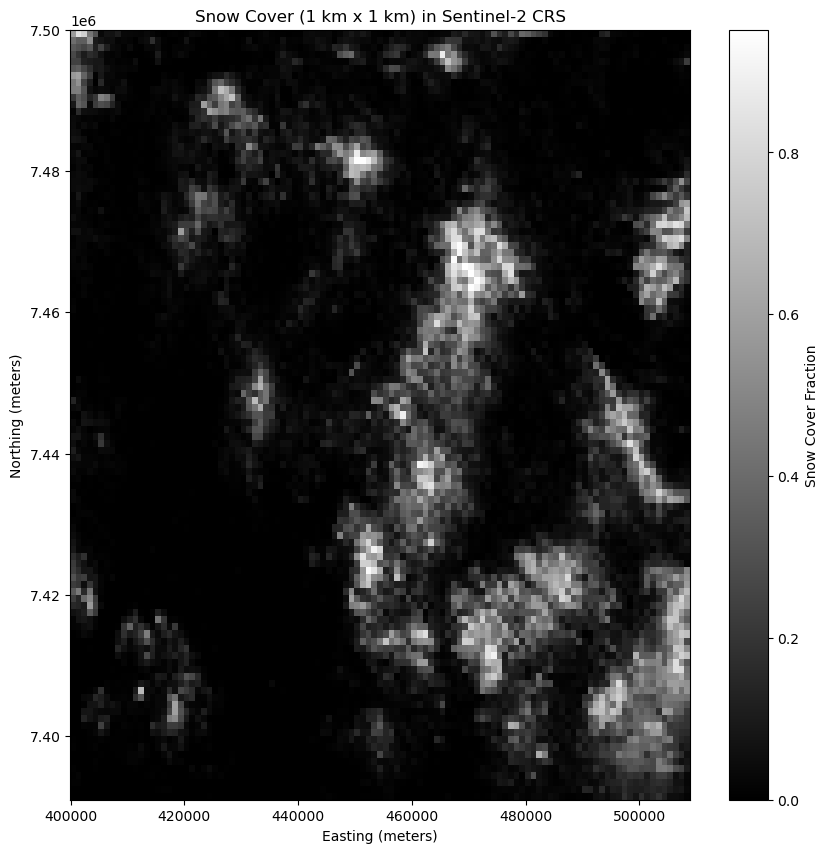

In [94]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"

band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band11_file = sentinel_path + "T35WMQ_20230515T095559_B11_20m.jp2"  # SWIR
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band11, transform_band11, crs_band11, src_band11 = load_raster(band11_file)
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask
    
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

def calculate_ndfsi(green_band, swir_band):
    """
    Calculate the NDFSI using Green (Band 3) and SWIR (Band 12).
    """
    ndfsi = (green_band - swir_band) / (green_band + swir_band)
    return ndfsi

ndfsi = calculate_ndfsi(band3, band11)

def apply_mask(ndfsi, mask):
    """
    Apply the mask to the NDFSI array. Masked areas will be set to NaN.
    """
    # Set NDFSI values where the mask is NaN to the NDFSI value, and everything else to NaN
    masked_ndfsi = np.where(np.isnan(mask), ndfsi, np.nan)
    return masked_ndfsi

masked_ndfsi = apply_mask(ndfsi, mask)

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

# Apply the threshold to create a binary snow mask
threshold = 0.4
snow_mask = apply_snow_threshold(masked_ndfsi, threshold)

def average_snow_cover_with_resize(snow_mask, transform, block_size_meters=1000):
    """
    Calculate the fractional snow cover in 1 km x 1 km blocks and resize the array to match the new resolution.
    Also, update the transform to match the resized array.
    """
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    # Calculate the number of pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / pixel_size_x)
    block_size_y = int(block_size_meters / pixel_size_y)
    
    # Get the dimensions of the snow mask
    rows, cols = snow_mask.shape
    
    # Calculate the dimensions of the new array
    new_rows = rows // block_size_y
    new_cols = cols // block_size_x
    
    # Initialize an array for the averaged snow cover with the new dimensions
    resized_snow_cover = np.full((new_rows, new_cols), np.nan, dtype=float)
    
    # Iterate over the new dimensions
    for i in range(new_rows):
        for j in range(new_cols):
            # Extract the block from the original array
            block = snow_mask[i*block_size_y:(i+1)*block_size_y, j*block_size_x:(j+1)*block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the resized array
            resized_snow_cover[i, j] = block_mean
    
    # Calculate the new transform for the resized array
    new_transform = rasterio.Affine(
        transform[0] * block_size_x, 0, transform[2],
        0, transform[4] * block_size_y, transform[5]
    )

    return resized_snow_cover, new_transform

averaged_snow_cover, new_transform = average_snow_cover_with_resize(snow_mask, transform_band3)

snow_left, snow_bottom = new_transform * (0, averaged_snow_cover.shape[0])
snow_right, snow_top = new_transform * (averaged_snow_cover.shape[1], 0)

plt.figure(figsize=(10, 10))
plt.imshow(averaged_snow_cover, cmap='gray', extent=(snow_left, snow_right, snow_bottom, snow_top), aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Snow Cover (1 km x 1 km) in Sentinel-2 CRS')
plt.show()

# DEM

In [74]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject
import matplotlib.pyplot as plt
from pyproj import Transformer

# Define the base directory containing DEM files
base_directory = '../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/'

def find_all_tif_files(base_dir):
    """
    Find all .tif files recursively in the given directory.
    """
    print("Searching for .tif files in the directory...")
    tif_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif'):
                full_path = os.path.join(root, file)
                tif_files.append(full_path)
                # print(f"Found: {full_path}")
    print(f"Total .tif files found: {len(tif_files)}")
    return tif_files

# Find all .tif files in the directory
dem_files = find_all_tif_files(base_directory)

def resample_and_merge_dems(dem_files):
    """
    Resample all DEM files to 10m resolution and merge them using rasterio's merge function.
    """
    datasets = []
    dem_crs = None

    for i, dem_file in enumerate(dem_files):
        # print(f"Processing file {i+1}/{len(dem_files)}: {dem_file}")
        with rasterio.open(dem_file) as src:
            if dem_crs == None:
                dem_crs = src.crs
            try:
                #resampled_data, resampled_transform, resampled_crs = resampled_data, src.transform*src.transform.scale(5,5), src.crs
                resampled_data = src.read(1, out_shape=(src.width//5, src.height//5), resampling=Resampling.average)

                memfile = MemoryFile()
                mem_dataset = memfile.open(
                    driver='GTiff',
                    height=resampled_data.shape[0],
                    width=resampled_data.shape[1],
                    count=1,
                    dtype=resampled_data.dtype,
                    crs=src.crs,
                    transform=src.transform*src.transform.scale(5,5)
                )
                mem_dataset.write(resampled_data, 1)
                # mem_dataset = create_memory_dataset(resampled_data, resampled_transform, resampled_crs)
                
                datasets.append(mem_dataset)
                # print(f"File {i+1} resampled and stored in memory.")
            except Exception as e:
                print(f"Error processing {dem_file}: {e}")

    # Merge the in-memory datasets
    try:
        mosaic, out_trans = merge(datasets)
        print("DEM merging completed.")
    except Exception as e:
        print(f"Error during merging: {e}")
        return None, None, None

    # Close all in-memory files
    for dataset in datasets:
        dataset.close()

    return mosaic, out_trans, dem_crs

merged_dem, merged_transform, dem_crs = resample_and_merge_dems(dem_files)

Searching for .tif files in the directory...
Total .tif files found: 324
DEM merging completed.


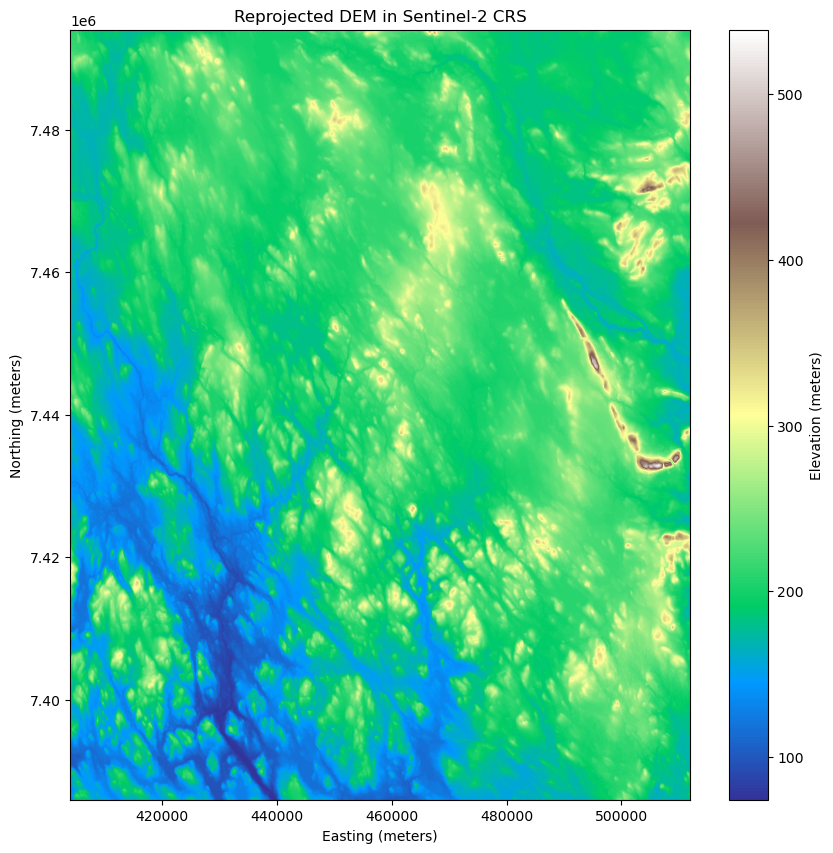

In [95]:
def reproject_dem_to_crs(src_array, src_transform, src_crs, dst_crs):
    """
    Reproject the DEM array to the target CRS (Sentinel-2 CRS).
    """
    width, height = src_array.shape[2], src_array.shape[1]

    # Calculate the bounding box from the source transform
    left, top = src_transform * (0, 0)
    right, bottom = src_transform * (width, height)
    
    # Calculate the transform and shape of the output array
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, left, bottom, right, top)

    # Prepare the destination array
    dst_array = np.empty((dst_height, dst_width), dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array[0],
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    return dst_array, dst_transform

# Reproject the merged DEM to match the Sentinel-2 CRS (crs_band3)
reprojected_dem, reprojected_transform = reproject_dem_to_crs(merged_dem, merged_transform, dem_crs, crs_band3)

dem_left, dem_bottom = reprojected_transform * (0, reprojected_dem.shape[0])
dem_right, dem_top = reprojected_transform * (reprojected_dem.shape[1], 0)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(reprojected_dem, cmap='terrain', extent=(dem_left, dem_right, dem_bottom, dem_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Combination

TypeError: Invalid shape (1, 1, 10800) for image data

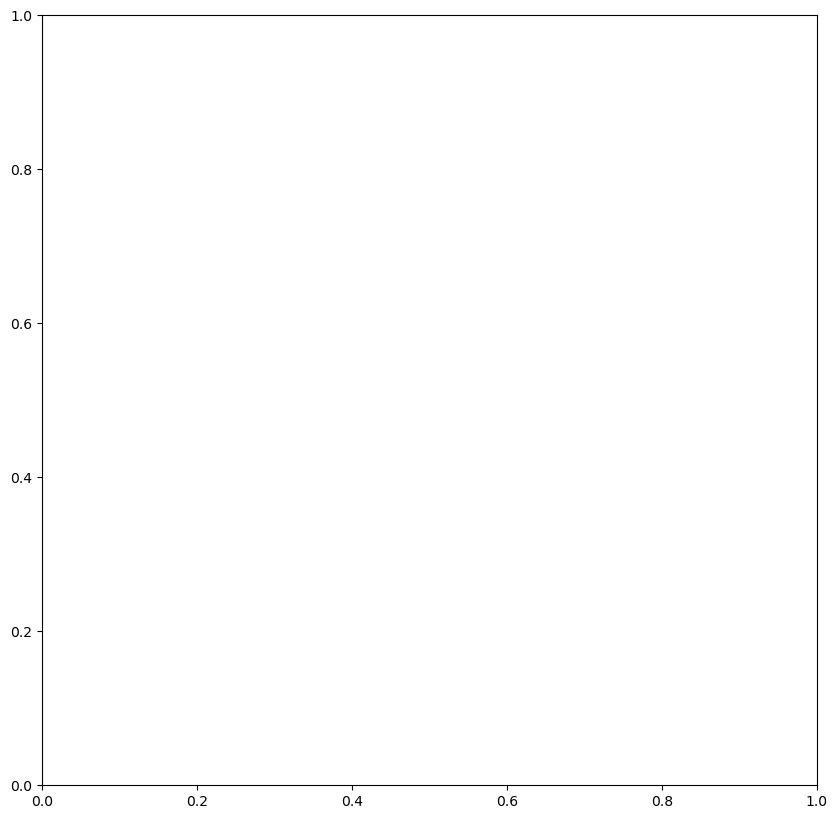

In [97]:
import numpy as np
import rasterio

def crop_to_overlap(array1, transform1, array2, transform2):
    """
    Crops two arrays to their overlapping area and returns the cropped arrays along with their updated transforms.

    Parameters:
    array1 (np.ndarray): The first array to crop.
    transform1 (Affine): The affine transformation of the first array.
    array2 (np.ndarray): The second array to crop.
    transform2 (Affine): The affine transformation of the second array.

    Returns:
    tuple: Cropped arrays and their corresponding updated transforms.
           (cropped_array1, new_transform1, cropped_array2, new_transform2)
    """
    # Get the bounding coordinates of both arrays
    left1, bottom1 = transform1 * (0, array1.shape[0])
    right1, top1 = transform1 * (array1.shape[1], 0)
    
    left2, bottom2 = transform2 * (0, array2.shape[0])
    right2, top2 = transform2 * (array2.shape[1], 0)

    # Calculate the overlapping bounds
    overlap_left = max(left1, left2)
    overlap_right = min(right1, right2)
    overlap_top = min(top1, top2)
    overlap_bottom = max(bottom1, bottom2)

    # If there's no overlap, return None
    if overlap_left >= overlap_right or overlap_bottom >= overlap_top:
        raise ValueError("The two arrays do not overlap.")

    # Calculate the new row and column indices for array1
    row_start1, col_start1 = ~transform1 * (overlap_left, overlap_top)
    row_end1, col_end1 = ~transform1 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start1 = max(0, int(np.floor(row_start1)))
    col_start1 = max(0, int(np.floor(col_start1)))
    row_end1 = min(array1.shape[0], int(np.ceil(row_end1)))
    col_end1 = min(array1.shape[1], int(np.ceil(col_end1)))

    # Crop array1
    cropped_array1 = array1[row_start1:row_end1, col_start1:col_end1]

    # Update the transform for the cropped array1
    new_transform1 = transform1 * rasterio.Affine.translation(col_start1, row_start1)

    # Calculate the new row and column indices for array2
    row_start2, col_start2 = ~transform2 * (overlap_left, overlap_top)
    row_end2, col_end2 = ~transform2 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start2 = max(0, int(np.floor(row_start2)))
    col_start2 = max(0, int(np.floor(col_start2)))
    row_end2 = min(array2.shape[0], int(np.ceil(row_end2)))
    col_end2 = min(array2.shape[1], int(np.ceil(col_end2)))

    # Crop array2
    cropped_array2 = array2[row_start2:row_end2, col_start2:col_end2]

    # Update the transform for the cropped array2
    new_transform2 = transform2 * rasterio.Affine.translation(col_start2, row_start2)

    return cropped_array1, new_transform1, cropped_array2, new_transform2


dem_cropped, dem_transform_cropped, snow_cropped, snow_transform_cropped = crop_to_overlap(
                                                                                merged_dem,
                                                                                merged_transform,
                                                                                averaged_snow_cover,
                                                                                new_transform)

c_left, c_bottom = reprojected_transform * (0, dem_cropped.shape[0])
c_right, c_top = reprojected_transform * (dem_cropped.shape[1], 0)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_cropped, cmap='terrain', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Topography

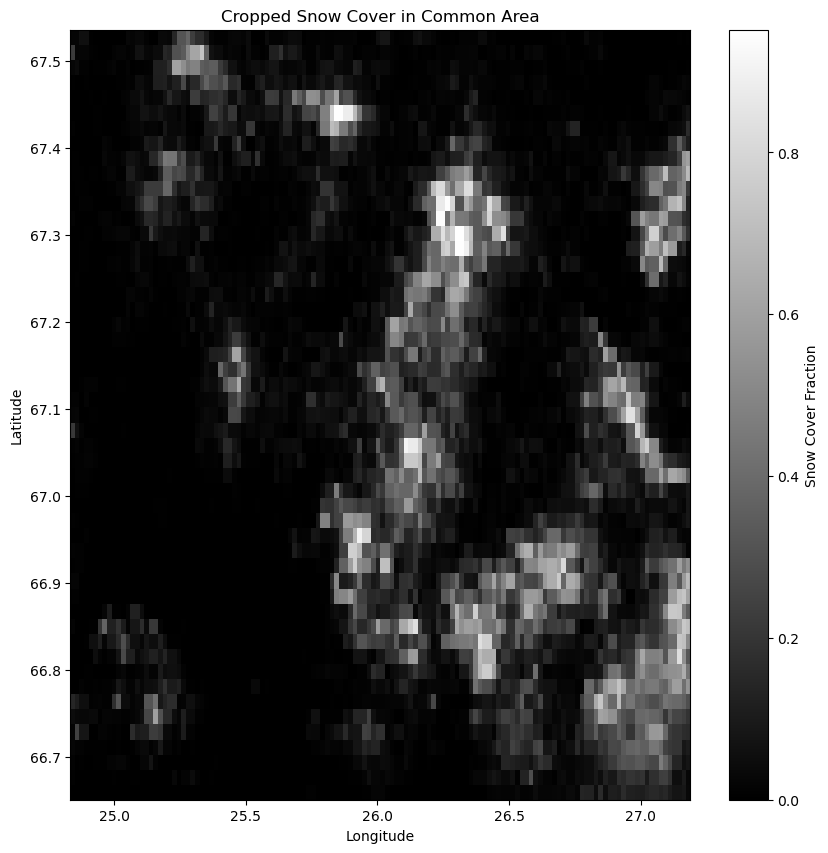

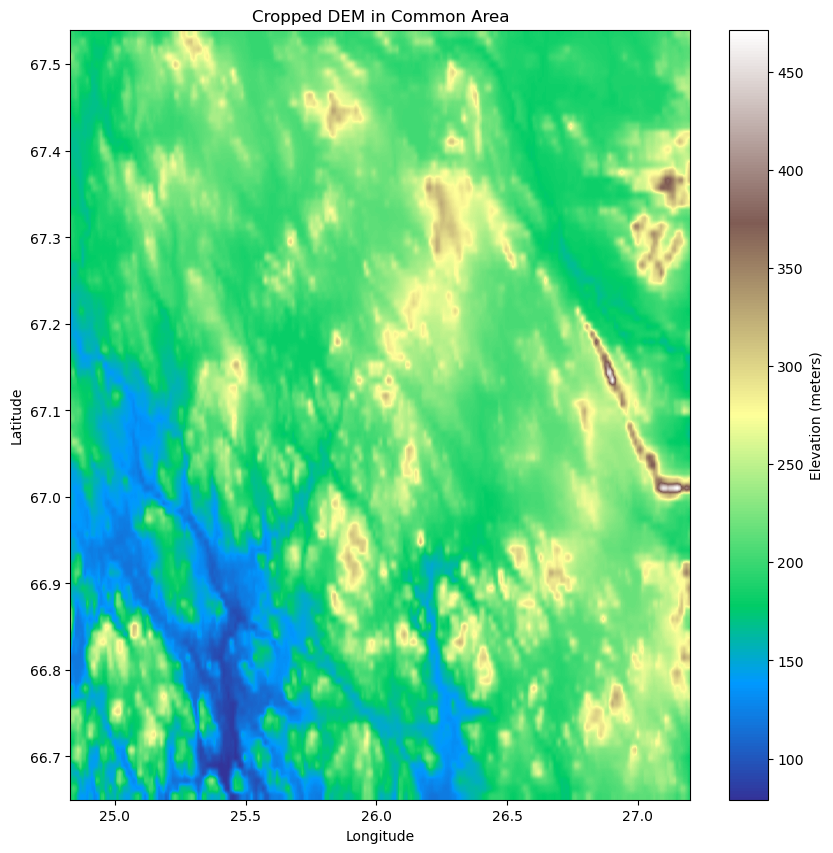

In [55]:
def average_dem_to_1km_resolution(dem_data, dem_lon, dem_lat, block_size_meters=1000):
    """
    Resample the DEM data to 1 km x 1 km resolution by averaging the values within each block.
    """
    # Calculate the pixel size in meters for longitude and latitude
    lon_pixel_size = abs(dem_lon[0, 1] - dem_lon[0, 0]) * 111320  # Approximate conversion for longitude to meters
    lat_pixel_size = abs(dem_lat[1, 0] - dem_lat[0, 0]) * 111320  # Approximate conversion for latitude to meters

    # Calculate the number of DEM pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / lon_pixel_size)
    block_size_y = int(block_size_meters / lat_pixel_size)

    # Get the dimensions of the DEM data
    rows, cols = dem_data.shape

    # Calculate the new dimensions for the resampled DEM data
    new_rows = rows // block_size_y
    new_cols = cols // block_size_x

    # Initialize an array for the averaged DEM data with the new dimensions
    resampled_dem = np.full((new_rows, new_cols), np.nan, dtype=float)

    # Iterate over the new dimensions
    for i in range(new_rows):
        for j in range(new_cols):
            # Extract the block from the original DEM data
            block = dem_data[i * block_size_y:(i + 1) * block_size_y, j * block_size_x:(j + 1) * block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the resampled DEM array
            resampled_dem[i, j] = block_mean

    return resampled_dem

# Apply the function
resampled_dem = average_dem_to_1km_resolution(cropped_dem, cropped_dem_lon, cropped_dem_lat, block_size_meters=1000)

# Plot the cropped snow cover data
plt.figure(figsize=(10, 10))
plt.imshow(cropped_snow_cover, extent=(cropped_snow_lon.min(), cropped_snow_lon.max(), cropped_snow_lat.min(), cropped_snow_lat.max()), cmap='gray', aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
# plt.yticks(np.arange(66.5,67.7,0.1))
# plt.xticks(np.arange(24.5,27.5,0.1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cropped Snow Cover in Common Area')
plt.show()

# Plot the cropped DEM data
plt.figure(figsize=(10, 10))
plt.imshow(resampled_dem, extent=(cropped_dem_lon.min(), cropped_dem_lon.max(), cropped_dem_lat.min(), cropped_dem_lat.max()), cmap='terrain', aspect='auto')
plt.colorbar(label='Elevation (meters)')
# plt.yticks(np.arange(66.5,67.7,0.1))
# plt.xticks(np.arange(24.5,27.5,0.1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cropped DEM in Common Area')
plt.show()

In [56]:
print(cropped_snow_cover.shape)
print(resampled_dem.shape)

(51, 134)
(100, 268)
